In [ ]:
!pip install opencv-python
!pip install -q gdown

In [ ]:
import cv2
cv2.__version__

'4.12.0'

In [ ]:
"https://drive.google.com/file/d/19LE8BbsSgclU-7E5J07pVCzoCfKaivSg/view?usp=sharing"

'https://drive.google.com/file/d/19LE8BbsSgclU-7E5J07pVCzoCfKaivSg/view?usp=sharing'

In [ ]:
file_id = "19LE8BbsSgclU-7E5J07pVCzoCfKaivSg"  # replace with your actual file ID
output = "all_images.zip"

In [ ]:
!gdown --id {file_id} -O {output}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19LE8BbsSgclU-7E5J07pVCzoCfKaivSg
From (redirected): https://drive.google.com/uc?id=19LE8BbsSgclU-7E5J07pVCzoCfKaivSg&confirm=t&uuid=eee90e31-b4aa-48a5-a06a-e0be6e9f9102
To: /content/all_images.zip
100% 624M/624M [00:08<00:00, 76.6MB/s]


In [ ]:
!unzip all_images.zip

Archive:  all_images.zip
  inflating: imaging_lens_position_7.0_cam_0_1730496602.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1730520171.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1730554202.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1730995601.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1730999359.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1730999404.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1731007802.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1731011402.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1731015002.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1731018602.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1731022202.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1731025802.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1731029402.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1731033002.jpg  
  inflating: imaging_lens_position_7.0_cam_0_1731036602.jpg  
  inflating: imaging_lens_position_7.0_cam_0_

In [ ]:
!mkdir all_images
!mv *.jpg all_images

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
import cv2
import numpy as np

def segment_plant_by_green(image_bgr, lG = 25, uG = 45, green_threshold=5000):
    """
    Segments green plant from background. Returns mask, segmented image,
    and boolean flag whether a plant is present.
    """
    control_bgr = cv2.imread('/content/all_images/imaging_lens_position_7.0_cam_0_1731299402.jpg')
    control_bgr = cv2.GaussianBlur(control_bgr, (3,3), 0)
    image_bgr = cv2.GaussianBlur(image_bgr, (3,3), 0)

    # Convert to HSV
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    control_hsv = cv2.cvtColor(control_bgr, cv2.COLOR_BGR2HSV)

    plant_diff = cv2.absdiff(image_hsv, control_hsv)

    #pick hue and saturation
    hue_diff = plant_diff[:,:,0]
    sat_diff = plant_diff[:,:,1]

    #set thresholds
    _, hue_thresh = cv2.threshold(hue_diff, 35, 70, cv2.THRESH_BINARY)
    _, sat_thresh = cv2.threshold(sat_diff, 60, 255, cv2.THRESH_BINARY)

    # Green color range (tweak if needed)
    lower_green = np.array([lG, 40, 40])
    upper_green = np.array([uG, 255, 255])

    # Create mask
    mask_2 = cv2.inRange(plant_diff, lower_green, upper_green)
    new_mask = cv2.bitwise_and(hue_thresh, sat_thresh)
    mask = cv2.bitwise_and(new_mask, new_mask, mask=new_mask)

    # Morphological cleaning
    kernel = np.ones((3, 3), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Morphological cleaning_2
    mask_clean_2 = cv2.morphologyEx(mask_2, cv2.MORPH_OPEN, kernel, iterations=2)

    # Count green pixels
    green_pixels = cv2.countNonZero(mask_clean)
    has_plant = green_pixels > green_threshold  # auto-skip threshold

    # Apply mask
    #result = cv2.bitwise_and(image_bgr, image_bgr, mask=mask_clean)
    result_2 = cv2.bitwise_and(image_bgr, image_bgr, mask=mask_clean_2)

    return mask_clean_2, result_2, has_plant


In [ ]:
mask_test = segment_plant_by_green(cv2.imread('/content/all_images/imaging_lens_position_7.0_cam_0_1732480202.jpg'))

In [ ]:
mask_test[1].shape

(4608, 2592, 3)

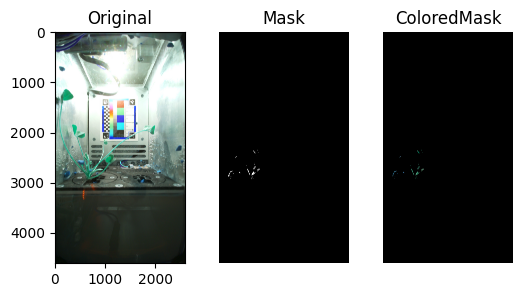

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(6, 3))

axes[0].imshow(cv2.imread('/content/all_images/imaging_lens_position_7.0_cam_0_1733268602.jpg'))
axes[0].set_title("Original")

axes[1].imshow(mask_test[0], cmap='gray')
axes[1].set_title("Mask")
axes[1].axis('off')


axes[2].imshow(mask_test[1], cmap='gray')
axes[2].set_title("ColoredMask")
axes[2].axis('off')


plt.show()

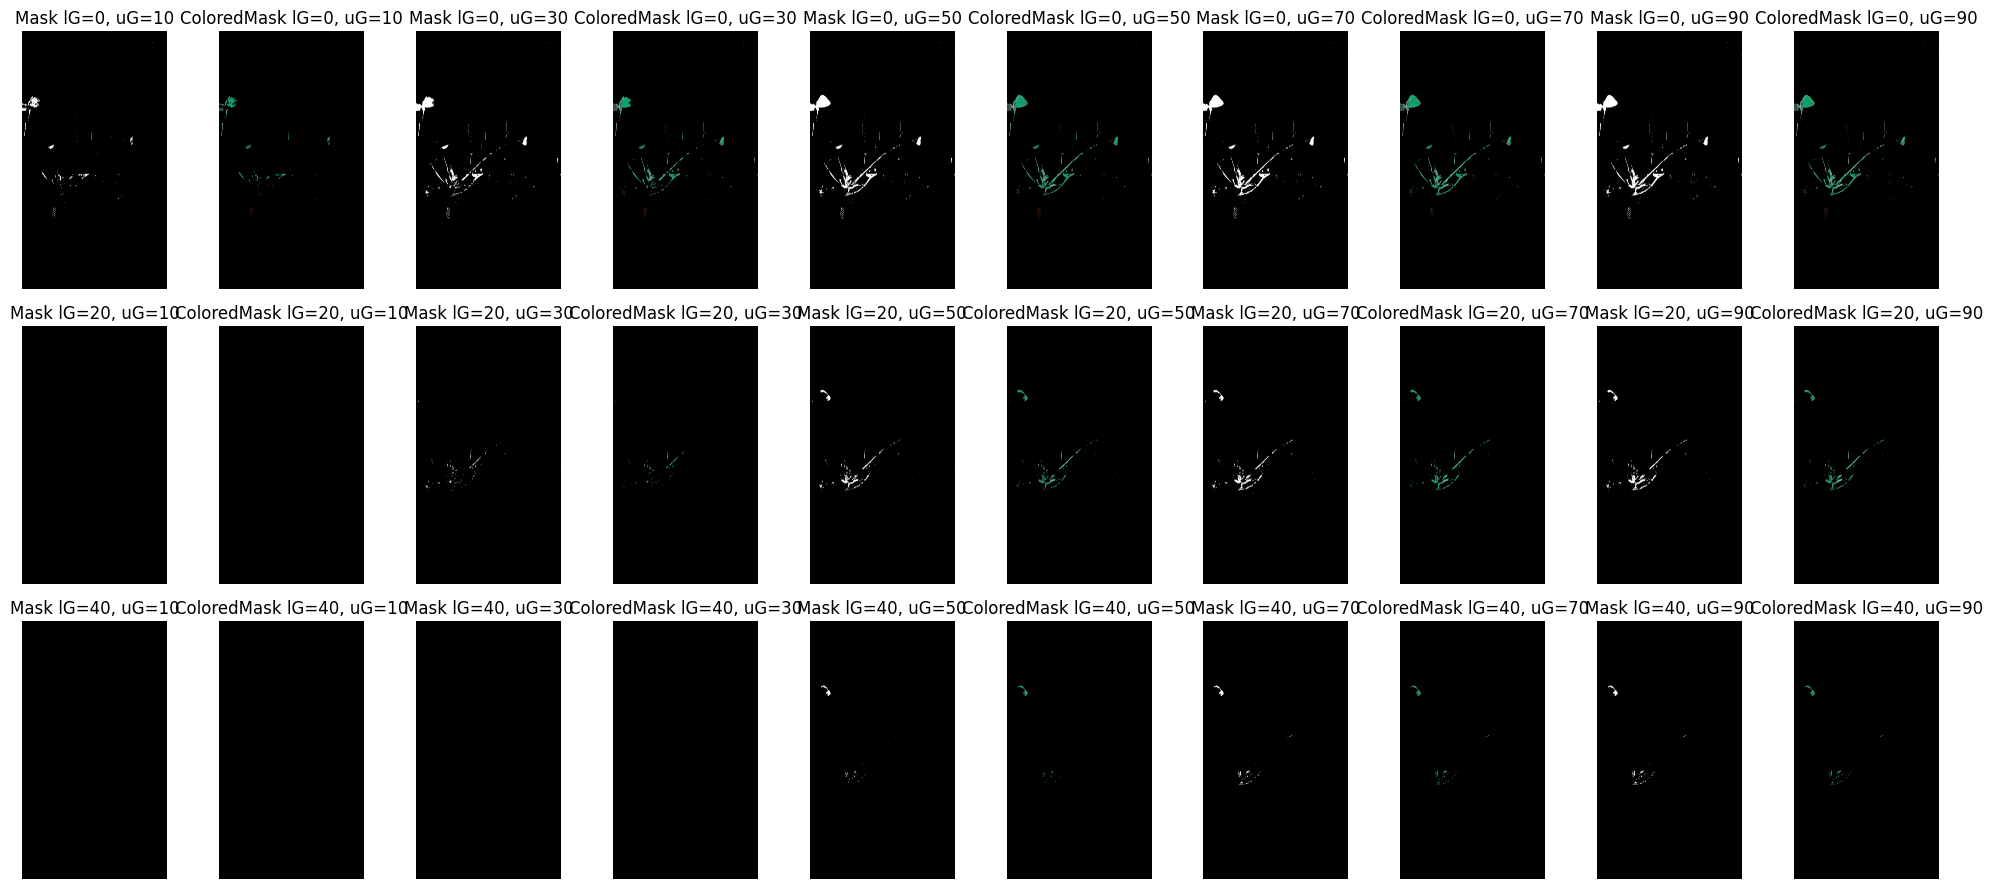

In [ ]:
#finding an optimal green filter

n = 0
num_lG = len(range(0,51,20))
num_uG = len(range(10,100,20))
total_plots_per_iteration = 2 # mask and colored mask
cols = num_uG * total_plots_per_iteration
fig, axes = plt.subplots(num_lG, cols, figsize=(cols * 2, num_lG * 3)) # Adjust figure size based on number of plots

row_idx = 0
for lG in range(0,51,20):
  col_idx = 0
  for uG in range(10,100,20):
    mask_test = segment_plant_by_green(cv2.imread('/content/all_images/imaging_lens_position_7.0_cam_0_1733268602.jpg'), lG=lG, uG=uG)
    axes[row_idx, col_idx].imshow(mask_test[0], cmap='gray')
    axes[row_idx, col_idx].set_title(f"Mask lG={lG}, uG={uG}")
    axes[row_idx, col_idx].axis('off')
    col_idx += 1

    axes[row_idx, col_idx].imshow(mask_test[1], cmap='gray')
    axes[row_idx, col_idx].set_title(f"ColoredMask lG={lG}, uG={uG}")
    axes[row_idx, col_idx].axis('off')
    col_idx += 1
  row_idx += 1

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

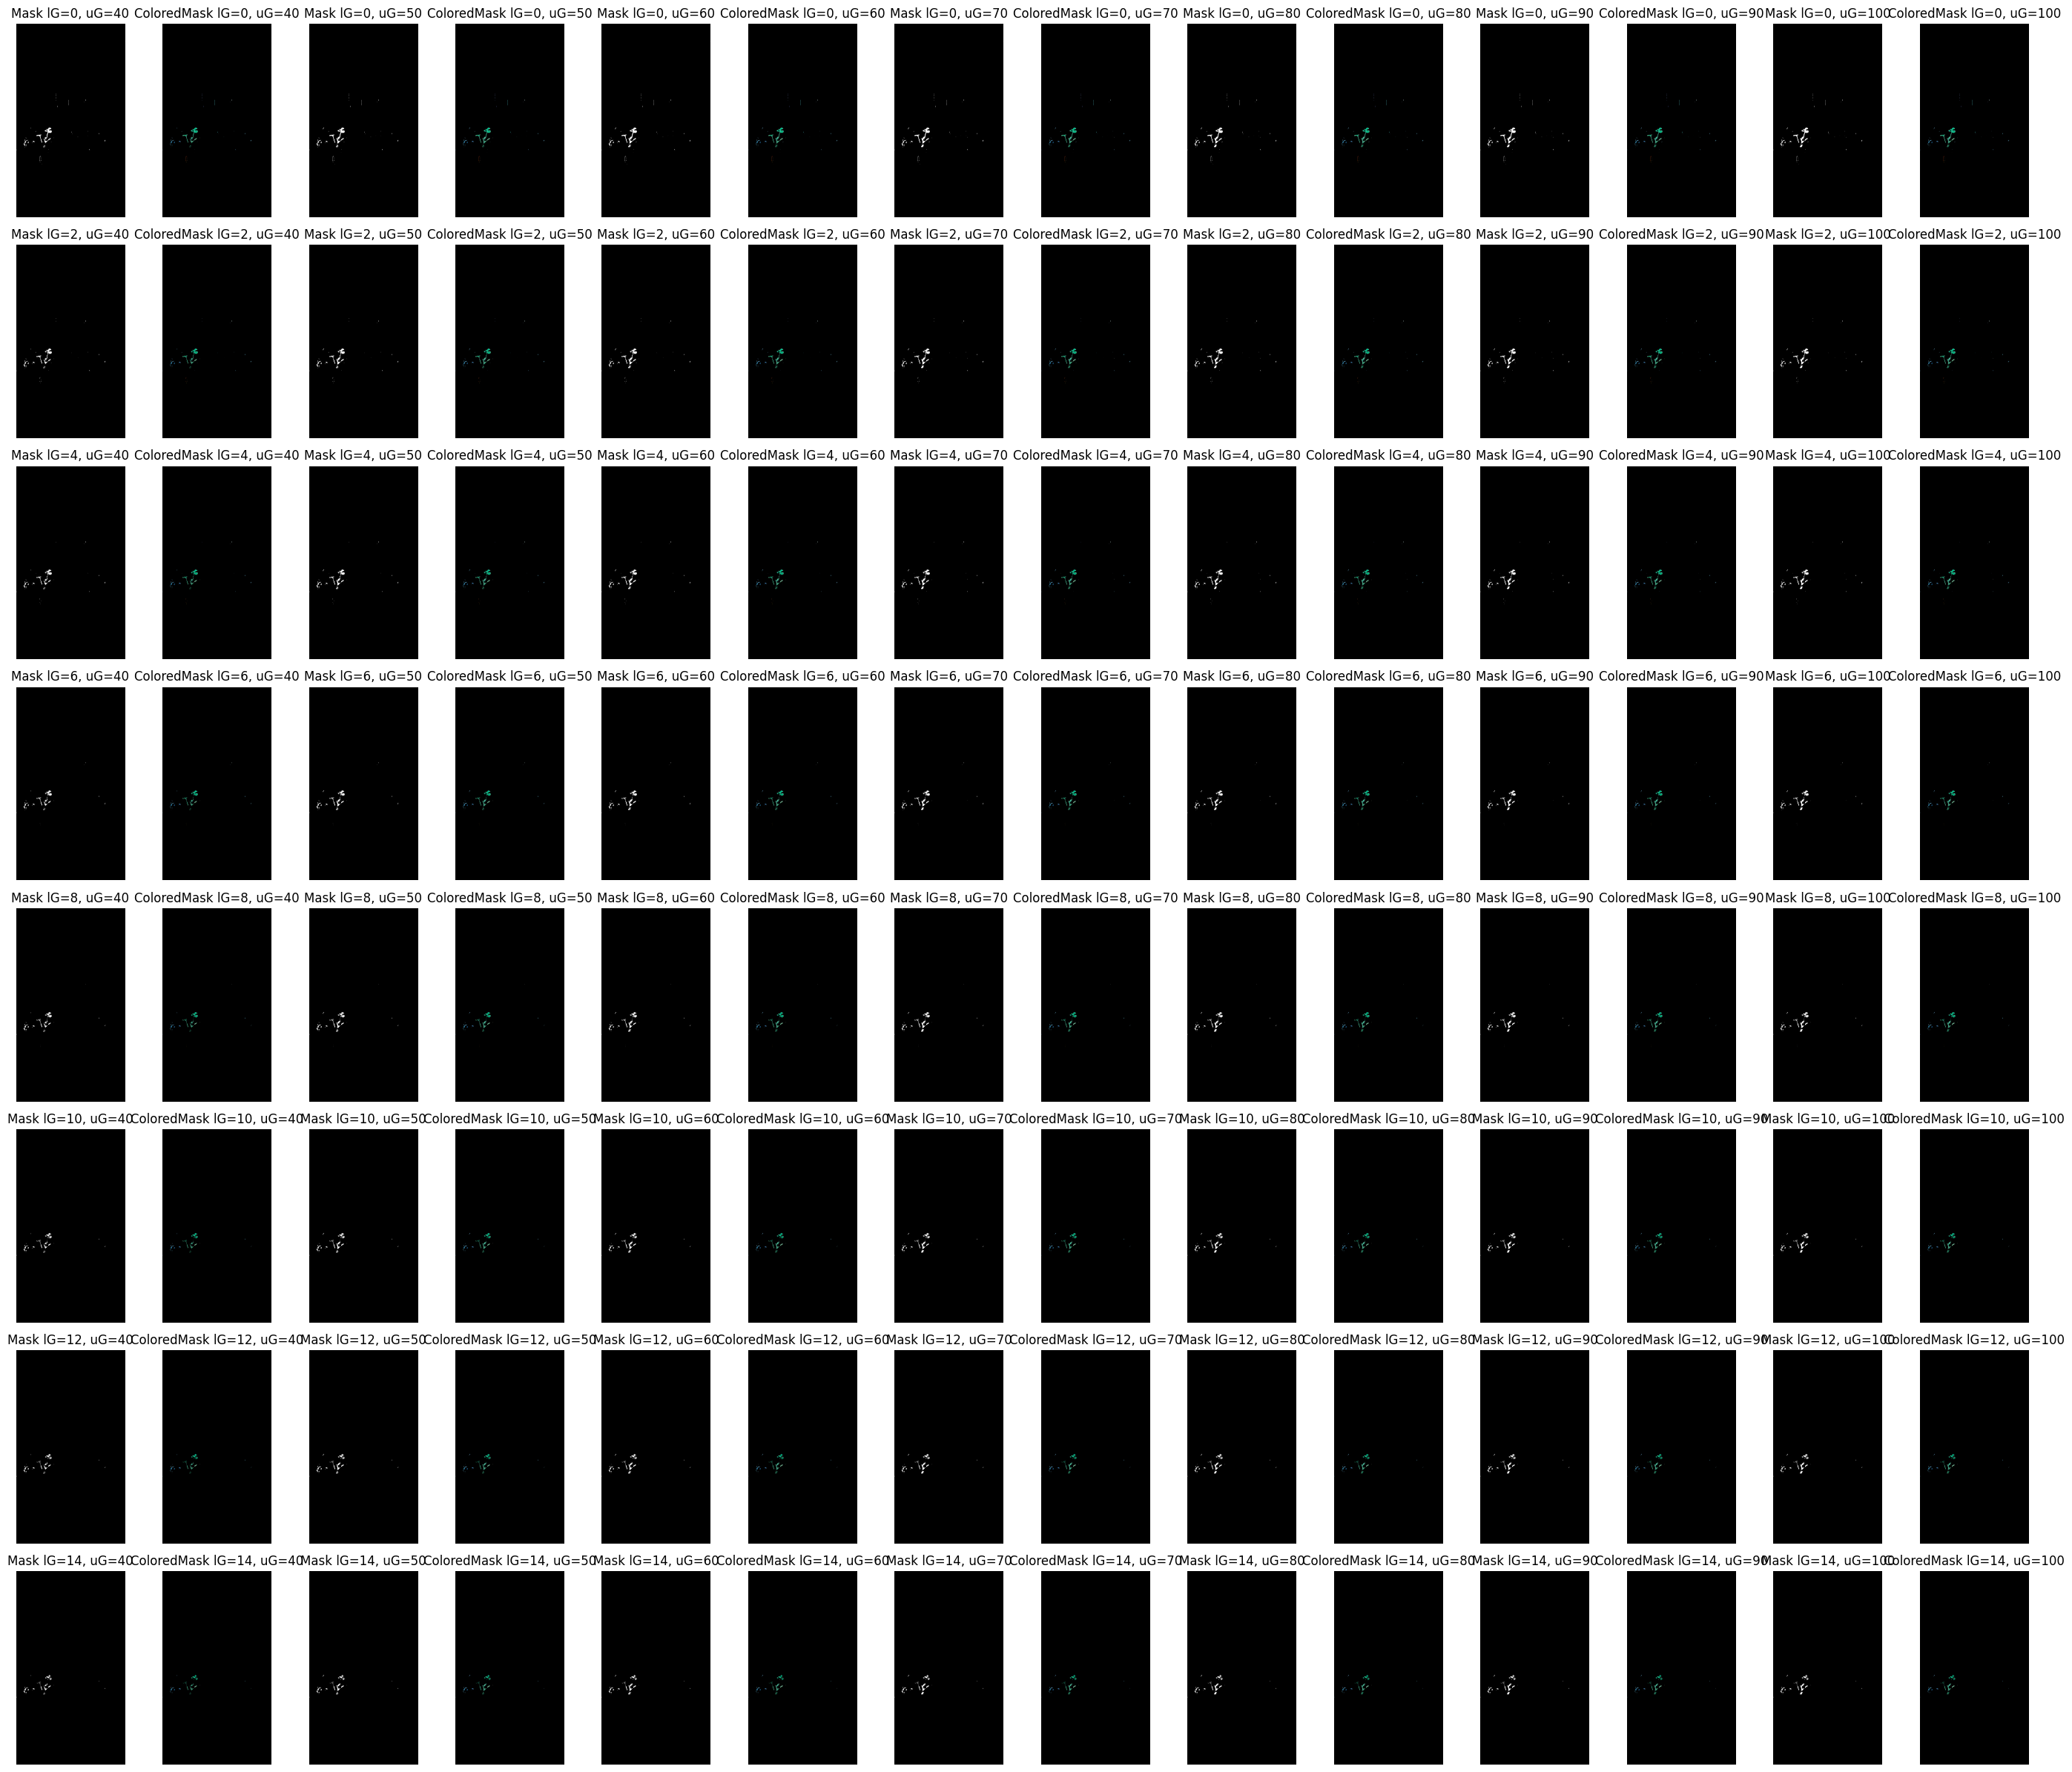

In [ ]:
#finding an optimal green filter

n = 0
num_lG = len(range(0,15,2))
num_uG = len(range(40,110,10))
total_plots_per_iteration = 2 # mask and colored mask
cols = num_uG * total_plots_per_iteration
fig, axes = plt.subplots(num_lG, cols, figsize=(cols * 2, num_lG * 3)) # Adjust figure size based on number of plots

row_idx = 0
for lG in range(0,15,2):
  col_idx = 0
  for uG in range(40,110,10):
    mask_test = segment_plant_by_green(cv2.imread('/content/all_images/imaging_lens_position_7.0_cam_0_1732289402.jpg'), lG=lG, uG=uG)
    axes[row_idx, col_idx].imshow(mask_test[0], cmap='gray')
    axes[row_idx, col_idx].set_title(f"Mask lG={lG}, uG={uG}")
    axes[row_idx, col_idx].axis('off')
    col_idx += 1

    axes[row_idx, col_idx].imshow(mask_test[1], cmap='gray')
    axes[row_idx, col_idx].set_title(f"ColoredMask lG={lG}, uG={uG}")
    axes[row_idx, col_idx].axis('off')
    col_idx += 1
  row_idx += 1

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

(np.float64(-0.5), np.float64(2591.5), np.float64(4607.5), np.float64(-0.5))

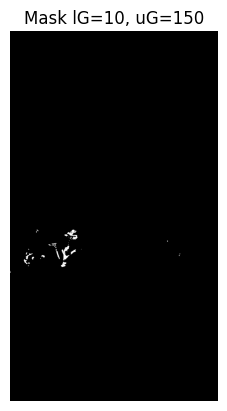

In [ ]:

lG = 10
uG = 150
mask_nr = segment_plant_by_green(cv2.imread('/content/all_images/imaging_lens_position_7.0_cam_0_1732289402.jpg'), lG=lG, uG=uG)
plt.imshow(mask_nr[0], cmap='gray')
plt.title(f"Mask lG={lG}, uG={uG}")
plt.axis('off')
#sns.scatterplot(x=stats[:, 0], y=stats[:, 1])

In [ ]:
mask_nr[1].shape

(4608, 2592, 3)

In [ ]:
def find_plant_height(mask_inp, genPlot = False):


  gray_nr = cv2.cvtColor(mask_inp, cv2.COLOR_BGR2GRAY)
  _, binary_nr = cv2.threshold(gray_nr, 1, 255, cv2.THRESH_BINARY)
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_nr) #inbuilt method for finding centroid of clusters

  #remove random blobs
  min_area = 500
  valid_components = [
      stats[i] for i in range(1, num_labels)
      if stats[i, cv2.CC_STAT_AREA] >= min_area
  ]
  y_top = min(comp[cv2.CC_STAT_TOP] for comp in valid_components)
  y_bottom = max(comp[cv2.CC_STAT_TOP] + comp[cv2.CC_STAT_HEIGHT] for comp in valid_components)

  if genPlot:
    plt.imshow(binary_nr, cmap='gray')
    plt.axis('off')
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], s = 5, color = 'blue')
    sns.scatterplot(x = [0,0], y = [y_top, y_bottom], color = 'red')

  return int(y_bottom - y_top)





464

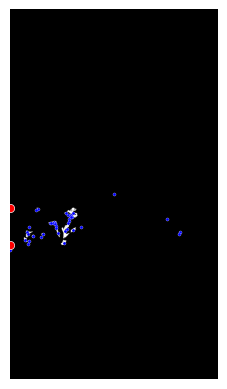

In [ ]:
find_plant_height(mask_nr[1], True)

In [ ]:
import os

fileName = []
plantStatus = []
plantHeight = []

for filename in os.listdir('/content/all_images/'):
    if filename.endswith('.jpg'):
        print(f'processing {filename}')
        image_path = os.path.join('/content/all_images/', filename)
        image_bgr = cv2.imread(image_path)
        mask, segmented_image, has_plant = segment_plant_by_green(image_bgr)

        if has_plant:
          plantHeight.append(find_plant_height(segmented_image))
        else:
          plantHeight.append(0)

        fileName.append(filename)
        plantStatus.append(has_plant)



processing imaging_lens_position_7.0_cam_0_1731252602.jpg
processing imaging_lens_position_7.0_cam_0_1732833002.jpg
processing imaging_lens_position_7.0_cam_0_1731090602.jpg
processing imaging_lens_position_7.0_cam_0_1732635002.jpg
processing imaging_lens_position_7.0_cam_0_1731799802.jpg
processing imaging_lens_position_7.0_cam_0_1731825002.jpg
processing imaging_lens_position_7.0_cam_0_1732869002.jpg
processing imaging_lens_position_7.0_cam_0_1732782602.jpg
processing imaging_lens_position_7.0_cam_0_1732163402.jpg
processing imaging_lens_position_7.0_cam_0_1733117402.jpg
processing imaging_lens_position_7.0_cam_0_1732671002.jpg
processing imaging_lens_position_7.0_cam_0_1731540602.jpg
processing imaging_lens_position_7.0_cam_0_1732393802.jpg
processing imaging_lens_position_7.0_cam_0_1732613402.jpg
processing imaging_lens_position_7.0_cam_0_1733232602.jpg
processing imaging_lens_position_7.0_cam_0_1731641402.jpg
processing imaging_lens_position_7.0_cam_0_1732426202.jpg
processing ima

In [ ]:
import pandas as pd
PlantStatusTab = pd.DataFrame({'fileName': fileName, 'plantStatus': plantStatus, 'plantHeight': plantHeight})

PlantStatusTab.to_csv('PlantStatusTab.csv')

In [ ]:
plantStatus.count(True)

432

In [ ]:
plantStatus.count(False)

212

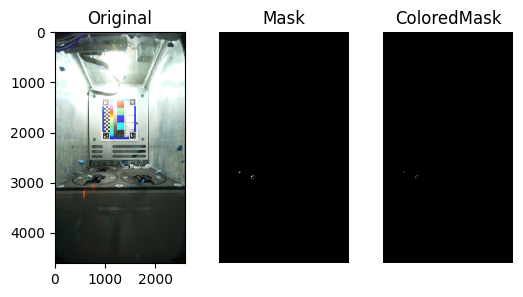

In [ ]:
curr_data = 'imaging_lens_position_7.0_cam_0_1731425402.jpg'

mask_test = segment_plant_by_green(cv2.imread(f'/content/all_images/{curr_data}'))


fig, axes = plt.subplots(1, 3, figsize=(6, 3))

axes[0].imshow(cv2.imread(f'/content/all_images/{curr_data}'))
axes[0].set_title("Original")

axes[1].imshow(mask_test[0], cmap='gray')
axes[1].set_title("Mask")
axes[1].axis('off')


axes[2].imshow(mask_test[1], cmap='gray')
axes[2].set_title("ColoredMask")
axes[2].axis('off')


plt.show()